# Group 35 Python Code

## Data Collection

### Scraping PDF content from Minutes

### Collecting Stockmarket data

### Creating a complete dataframe

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

#import repo
path_repo = 'https://raw.githubusercontent.com/MatPiq/SDS-Group-35/master/Exam_Project/historic_data/reporate.csv'
cols = ['date_announcement', 'repoann', 'repoeff']
repo = pd.read_csv(path_repo, sep=';', error_bad_lines=False, names = cols,)

path_stock = ''




In [13]:
fig = plt.figure()
ax = plt.subplot(figsize=(10, 5))
ax.plot('date_announcement', 'repoann', data = repo)
plt.title('Repo Rate')


AttributeError: Unknown property figsize

<Figure size 432x288 with 0 Axes>

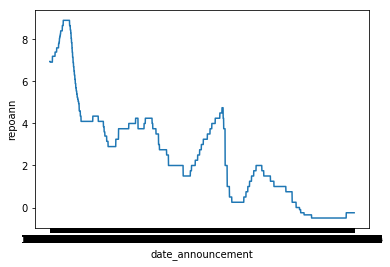

In [12]:
sns.lineplot(x = 'date_announcement', y = 'repoann', data = repo)

### Dataframe quality assorance and validation

## Sentiment analysis

### Model validation

## Machine learning Model

### Model validation